In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import random
import time
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#Downloading the MNIST dataset 
train_data = datasets.MNIST(root='./data',train=True,  download=True)
#Calculating means and standard deviations for train_data
means = np.array(train_data.data).mean(axis = (0,1,2)) / 255
stds = np.array(train_data.data).std(axis = (0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: 0.1306604762738429
Calculated stds: 0.30810780385646264


In [ ]:
#Using torchvisions.transforms for common image transformations
transform = transforms.Compose([transforms.Resize((50)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [ ]:
# applying the transformations on train and test data
train_data = datasets.MNIST(root='./data',train=True,  download=True, 
                              transform = transform)

test_data = datasets.MNIST(root='./data',train=False,  download=True, 
                             transform = transform)

In [ ]:
#splitting into train and validation data
n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples

data_train, valid_data = torch.utils.data.random_split(train_data, 
                                                       [n_train_examples, n_valid_examples])

In [ ]:
print(f'Number of training examples: {len(data_train)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [ ]:
BATCH_SIZE = 64
#dataloader to access images in the dataset
train_iterator = torch.utils.data.DataLoader(data_train, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size = BATCH_SIZE)

In [ ]:
next(iter(train_iterator))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm):
        super().__init__()
        
        modules = []
        modules.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        if batch_norm:
            modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU(inplace=True))
    
        self.block = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.block(x)

In [ ]:
class VGG11(nn.Module):
    def __init__(self, output_dim, block, pool, batch_norm):
        super().__init__()
        
        self.features = nn.Sequential(
            block(1, 64, batch_norm), #in_channels, out_channels
            pool(2, 2), #kernel_size, stride
            block(64, 128, batch_norm),
            pool(2, 2),
            block(128, 256, batch_norm),
            block(256, 256, batch_norm),
            pool(2, 2),
            block(256, 512, batch_norm),
            block(512, 512, batch_norm),
            pool(2, 2),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            pool(2, 2),
        )
        
        self.classifier = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
class VGG16(nn.Module):
    def __init__(self, output_dim, block, pool, batch_norm):
        super().__init__()
        
        self.features = nn.Sequential(
            block(1, 64, batch_norm),
            block(64, 64, batch_norm),
            pool(2, 2),
            block(64, 128, batch_norm),
            block(128, 128, batch_norm),
            pool(2, 2),
            block(128, 256, batch_norm),
            block(256, 256, batch_norm),
            block(256, 256, batch_norm),
            pool(2, 2),
            block(256, 512, batch_norm),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            pool(2, 2),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            pool(2, 2),
        )
        
        self.classifier = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
class VGG19(nn.Module):
    def __init__(self, output_dim, block, pool, batch_norm):
        super().__init__()
        
        self.features = nn.Sequential(
            block(1, 64, batch_norm),
            block(64, 64, batch_norm),
            pool(2, 2),
            block(64, 128, batch_norm),
            block(128, 128, batch_norm),
            pool(2, 2),
            block(128, 256, batch_norm),
            block(256, 256, batch_norm),
            block(256, 256, batch_norm),
            block(256, 256, batch_norm),
            pool(2, 2),
            block(256, 512, batch_norm),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            pool(2, 2),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            block(512, 512, batch_norm),
            pool(2, 2),
        )
        
        self.classifier = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
OUTPUT_DIM = 10
BATCH_NORM = True

vgg11_model = VGG11(OUTPUT_DIM, VGGBlock, nn.MaxPool2d, BATCH_NORM) 
vgg16_model = VGG16(OUTPUT_DIM, VGGBlock, nn.MaxPool2d, BATCH_NORM) 
vgg19_model = VGG19(OUTPUT_DIM, VGGBlock, nn.MaxPool2d, BATCH_NORM) 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'VGG11 has {count_parameters(vgg11_model):,} trainable parameters')



VGG11 has 9,229,962 trainable parameters


## VGG 11


In [ ]:
#defining the model
model = VGG11(OUTPUT_DIM, VGGBlock, nn.MaxPool2d, BATCH_NORM) 

In [ ]:
model

VGG11(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): VGGBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): VGGBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
   

In [ ]:
#initialising adam optimzer with  low learning rate
optimizer = optim.Adam(model.parameters())

In [ ]:
#using cross entropy as loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#placing the model and loss function on device
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# calculating accuracy
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [ ]:
def train_model(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
     #training the model

    
    for (x, y) in iterator:
         #x has batch of images
      # y has labels for the batch of images
        
        x = x.to(device)
       # moving x and y to device
        y = y.to(device)
        #setting the gradients of all parameters to zero

        optimizer.zero_grad()
        
        fx = model(x)
         #caclulating loss

        loss = criterion(fx, y)
        #accuracy is computed
        acc = calculate_accuracy(fx, y)
        # back propogating the loss
        loss.backward()
        #updating the optimizer
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:
          #x has batch of images
      # y has labels for the batch of images
        # moving x and y to device

            x = x.to(device)
            y = y.to(device)

            fx = model(x)
            #caclulating loss
            loss = criterion(fx, y)
             #accuracy is computed
            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#creating empty lists for storing loss and accuracy values while training
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

In [ ]:

EPOCHS = 50

best_valid_loss = float('inf')


for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion, device)
    
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    end_time = time.time()
    # storing the loss for each epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # storing the accuracy for each epoch
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    t = time.localtime()

    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', t)
    print(timestamp)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

2021-05-15 00:28:16
Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.113 | Train Acc: 96.67%
	 Val. Loss: 0.080 |  Val. Acc: 97.69%
2021-05-15 00:28:51
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 0.041 | Train Acc: 98.71%
	 Val. Loss: 0.049 |  Val. Acc: 98.62%
2021-05-15 00:29:25
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.034 | Train Acc: 98.97%
	 Val. Loss: 0.044 |  Val. Acc: 98.76%
2021-05-15 00:29:59
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.027 | Train Acc: 99.11%
	 Val. Loss: 0.036 |  Val. Acc: 99.08%
2021-05-15 00:30:32
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.023 | Train Acc: 99.28%
	 Val. Loss: 0.044 |  Val. Acc: 98.88%
2021-05-15 00:31:07
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.021 | Train Acc: 99.34%
	 Val. Loss: 0.041 |  Val. Acc: 98.87%
2021-05-15 00:31:41
Epoch: 07 | Epoch Time: 0m 33s
	Train Loss: 0.019 | Train Acc: 99.38%
	 Val. Loss: 0.037 |  Val. Acc: 98.96%
2021-05-15 00:32:16
Epoch: 08 | Epoch Time: 0m 35s
	Train Loss: 0.017 | Train Acc: 99.44%
	 Val. 

In [ ]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.025 | Test Acc: 99.35%


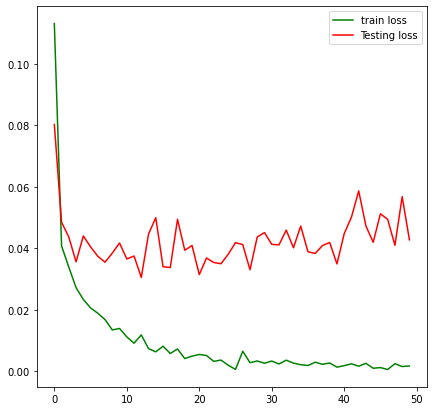

In [ ]:
#plotting the loss
plt.figure(figsize=(7, 7))
plt.plot(train_losses, color='green', label='train loss')
plt.plot(valid_losses, color='red', label='Testing loss')
plt.legend()
plt.show()

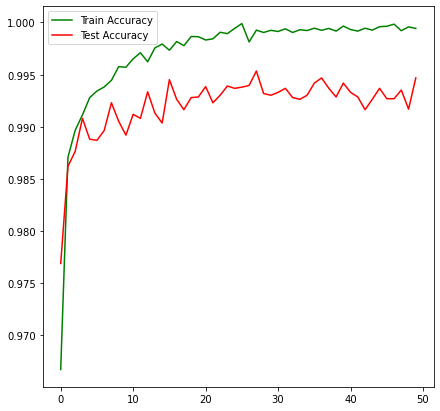

In [ ]:
#plotting the accuracy
plt.figure(figsize=(7, 7))
plt.plot(train_accuracy, color='green', label='Train Accuracy')
plt.plot(valid_accuracy, color='red', label='Test Accuracy')
plt.legend()
plt.show()

## VGG 16

In [ ]:
  #defining the model
model_2 = VGG16(OUTPUT_DIM, VGGBlock, nn.MaxPool2d, BATCH_NORM) 

In [ ]:
print(f'VGG16 has {count_parameters(vgg16_model):,} trainable parameters')

VGG16 has 14,727,114 trainable parameters


In [ ]:
model_2

VGG16(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): VGGBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (4): VGGBlock(
      (block): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3

In [ ]:
#initialising adam optimzer with  low learning rate
optimizer = optim.Adam(model_2.parameters())

In [ ]:
#using cross entropy as loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
#placing the model and loss function on device
model_2 = model_2.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [ ]:
def train(model_2, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    #training the model
    model_2.train()
     #x has batch of images
      # y has labels for the batch of images
    for (x, y) in iterator:
        # moving x and y to device
        x = x.to(device)
        y = y.to(device)
        #setting the gradients of all parameters to zero  
        optimizer.zero_grad()
                
        fx = model_2(x)
        #caclulating loss
        loss = criterion(fx, y)
         #accuracy is computed
        acc = calculate_accuracy(fx, y)
        # back propogating the loss
        loss.backward()
        #updating the optimizer
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model_2, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model_2.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model_2(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_losses2 = []
valid_losses2 = []
train_accuracy2 = []
valid_accuracy2 = []

In [ ]:
EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_2, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model_2, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_2.state_dict(), 'tut5-model_2.pt')
    
    end_time = time.time()
    
    train_losses2.append(train_loss)
    valid_losses2.append(valid_loss)
    
    train_accuracy2.append(train_acc)
    valid_accuracy2.append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    t = time.localtime()

    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', t)
    print(timestamp)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

2021-05-15 00:56:56
Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 0.243 | Train Acc: 91.63%
	 Val. Loss: 0.071 |  Val. Acc: 97.94%
2021-05-15 00:57:43
Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 0.059 | Train Acc: 98.17%
	 Val. Loss: 0.069 |  Val. Acc: 98.19%
2021-05-15 00:58:29
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 0.044 | Train Acc: 98.72%
	 Val. Loss: 0.053 |  Val. Acc: 98.38%
2021-05-15 00:59:16
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 0.039 | Train Acc: 98.84%
	 Val. Loss: 0.049 |  Val. Acc: 98.52%
2021-05-15 01:00:03
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.034 | Train Acc: 98.97%
	 Val. Loss: 0.046 |  Val. Acc: 98.70%
2021-05-15 01:00:49
Epoch: 06 | Epoch Time: 0m 46s
	Train Loss: 0.032 | Train Acc: 99.06%
	 Val. Loss: 0.035 |  Val. Acc: 98.95%
2021-05-15 01:01:35
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.026 | Train Acc: 99.23%
	 Val. Loss: 0.055 |  Val. Acc: 98.70%
2021-05-15 01:02:21
Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 0.027 | Train Acc: 99.19%
	 Val. 

In [ ]:
model_2.load_state_dict(torch.load('tut5-model_2.pt'))

test_loss, test_acc = evaluate(model_2, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.023 | Test Acc: 99.41%


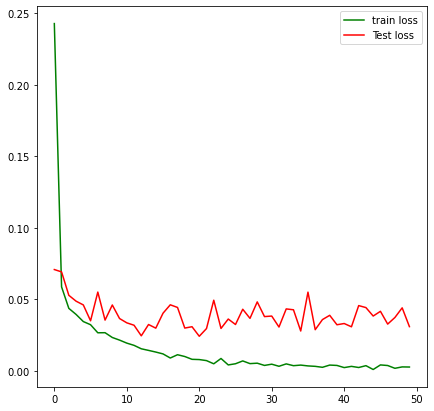

In [ ]:

plt.figure(figsize=(7, 7))
plt.plot(train_losses2, color='green', label='train loss')
plt.plot(valid_losses2, color='red', label='Test loss')
plt.legend()
plt.show()

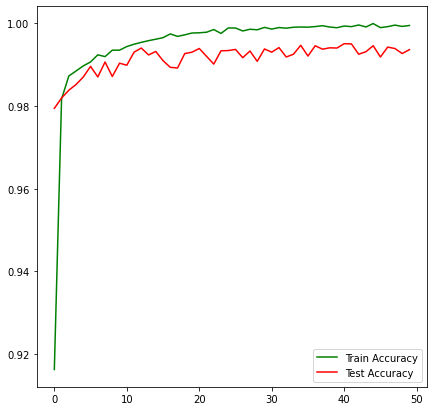

In [ ]:

plt.figure(figsize=(7, 7))
plt.plot(train_accuracy2, color='green', label='Train Accuracy')
plt.plot(valid_accuracy2, color='red', label='Test Accuracy')
plt.legend()
plt.show()

# VGG 19

In [ ]:
model_3 = VGG19(OUTPUT_DIM, VGGBlock, nn.MaxPool2d, BATCH_NORM) 

In [ ]:

print(f'VGG19 has {count_parameters(vgg19_model):,} trainable parameters')

VGG19 has 20,039,370 trainable parameters


In [ ]:
model_3

VGG19(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): VGGBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (4): VGGBlock(
      (block): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3

In [ ]:
optimizer = optim.Adam(model_3.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model_3 = model_3.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [ ]:
def train(model_3, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model_3.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model_3(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def train(model_3, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model_3.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model_3(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model_3, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model_3.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model_3(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

train_losses3 = []
valid_losses3 = []
train_accuracy3 = []
valid_accuracy3 = []


In [ ]:
EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_3, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model_3, valid_iterator, criterion, device)
    
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_3.state_dict(), 'tut5-model_3.pt')
    
    end_time = time.time()
    
    train_losses3.append(train_loss)
    valid_losses3.append(valid_loss)
    
    train_accuracy3.append(train_acc)
    valid_accuracy3.append(valid_acc)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    t = time.localtime()

    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', t)
    print(timestamp)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

2021-05-15 01:35:28
Epoch: 01 | Epoch Time: 0m 59s
	Train Loss: 0.294 | Train Acc: 90.63%
	 Val. Loss: 0.073 |  Val. Acc: 98.04%
2021-05-15 01:36:26
Epoch: 02 | Epoch Time: 0m 57s
	Train Loss: 0.073 | Train Acc: 97.86%
	 Val. Loss: 0.053 |  Val. Acc: 98.73%
2021-05-15 01:37:23
Epoch: 03 | Epoch Time: 0m 56s
	Train Loss: 0.051 | Train Acc: 98.49%
	 Val. Loss: 0.060 |  Val. Acc: 98.39%
2021-05-15 01:38:22
Epoch: 04 | Epoch Time: 0m 58s
	Train Loss: 0.044 | Train Acc: 98.76%
	 Val. Loss: 0.046 |  Val. Acc: 98.91%
2021-05-15 01:39:19
Epoch: 05 | Epoch Time: 0m 57s
	Train Loss: 0.042 | Train Acc: 98.83%
	 Val. Loss: 0.051 |  Val. Acc: 98.41%
2021-05-15 01:40:17
Epoch: 06 | Epoch Time: 0m 57s
	Train Loss: 0.036 | Train Acc: 99.01%
	 Val. Loss: 0.047 |  Val. Acc: 98.74%
2021-05-15 01:41:15
Epoch: 07 | Epoch Time: 0m 58s
	Train Loss: 0.035 | Train Acc: 99.03%
	 Val. Loss: 0.042 |  Val. Acc: 98.92%
2021-05-15 01:42:11
Epoch: 08 | Epoch Time: 0m 55s
	Train Loss: 0.031 | Train Acc: 99.17%
	 Val. 

In [ ]:
model_3.load_state_dict(torch.load('tut5-model_3.pt'))

test_loss, test_acc = evaluate(model_3, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}%')

Test Loss: 0.022 | Test Accuracy: 99.53%


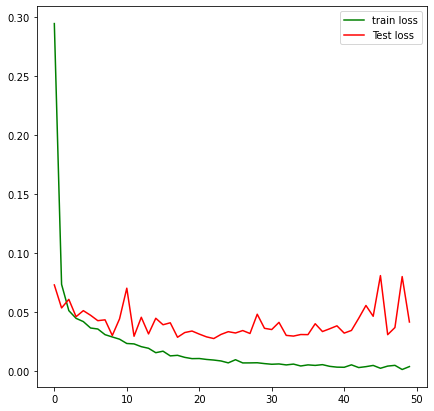

In [ ]:

plt.figure(figsize=(7, 7))
plt.plot(train_losses3, color='green', label='train loss')
plt.plot(valid_losses3, color='red', label='Test loss')
plt.legend()
plt.show()




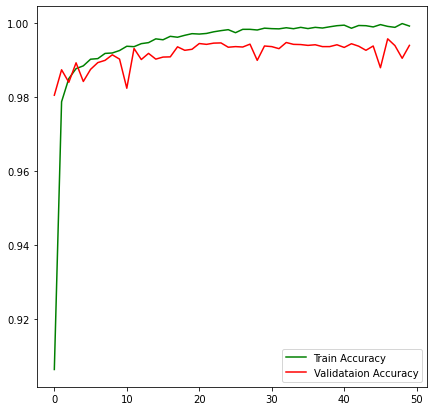

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(train_accuracy3, color='green', label='Train Accuracy')
plt.plot(valid_accuracy3, color='red', label='Validataion Accuracy')
plt.legend()
plt.show()